# Analysis E-Commerce Product Reviews Using NLP

# 1. Import Libary

In [1]:
#import the generic libaries
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv

#import nltk libaries
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack


lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

#visualization libaries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image #for word cloud image

# #sapcy fotr preprocessing
# import spacy
# import scipy.sparse
# from spacy.alng.en.stop_words import STOP_WORDS
# nlp = spacy.load('en_core_web_sm')

#spell checker
# !pip install pyspellchecker
from spellchecker import SpellChecker

# Keras 
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
# from keras.callbacks import ModelCheckerpoint
from keras.models import load_model
from keras.optimizers import Adam

#to change date to datetime
import datetime
import time

#textblob
from textblob import TextBlob

# To show all the columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

# to pickle dataframe
import pickle

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Load Dataset

In [2]:
df = pd.read_csv('GrammarandProductReviews.csv')
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universalmusicgroupcashmoney/14331328,pinkfridayromanreloadedreupwdvd/000000000,pinkfridayromanreloadedreupwdvd/b009ntnhju,0602537205981",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.000Z,2017-12-20T12:28:00.000Z,2017-12-16T05:40:00.000Z,2017-12-07T09:27:00.000Z,2017-11-18T22:25:00.000Z",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/reviews/14331328?sort=helpfulness_desc&limit=200&offset=0,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,067981934427,0067981934427,kylovesensualitypleasuregel/553550989,kylovesensualitypleasuregel/b014gk947e,ky/067981934427",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,06798193442

# 3. Text Pre-processing

In [3]:
#check shape of dataset
df.shape

(71044, 25)

In this dataset we have 71044 rows and 25 columns

In [4]:
print('Columns : \n',df.columns)

Columns : 
 Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')


In [5]:
# Rename the columns
col_names = df.columns
new_col_names= [i.replace('.','_') for i in col_names]
df.columns = new_col_names

In [6]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews_date',
       'reviews_dateAdded', 'reviews_dateSeen', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_id', 'reviews_numHelpful',
       'reviews_rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'upc'],
      dtype='object')

now we successfully remove the dot from the variable center and put an underscore for joining two variable

In [7]:
# getting information related to dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews_date          70977 non-null  object 
 11  reviews_dateAdded     71044 non-null  object 
 12  reviews_dateSeen      71044 non-null  object 
 13  reviews_didPurchase   32158 non-null  object 
 14  reviews_doRecommend   60429 non-null  object 
 15  reviews_id         

#### Information About Dataset:
    

1. In this dataset we see that null values are present in dataset columns.

2. out of 25 columns 22 columns are object-type datasets and others are numerical type

In [8]:
# count missing values in particular columns
print('Missing Value Count : \n',df.isnull().sum())

Missing Value Count : 
 id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews_date               67
reviews_dateAdded           0
reviews_dateSeen            0
reviews_didPurchase     38886
reviews_doRecommend     10615
reviews_id              38886
reviews_numHelpful      38536
reviews_rating              0
reviews_sourceURLs          0
reviews_text               36
reviews_title             476
reviews_userCity        65634
reviews_userProvince    70595
reviews_username           96
upc                         2
dtype: int64


as we see that null values are present in ean, manufacture, manufacture number,
reviews_date, reviews_didPurchase, reviews_doRecommend, reviews_id,
reviews_numHelpful, reviews_text, reviews_userCity, reviews_userProvince,
reviews_username, upc

In [9]:
# Percentage of missing values per columns
df.isna().mean().round(4)*100

id                       0.00
brand                    0.00
categories               0.00
dateAdded                0.00
dateUpdated              0.00
ean                     45.01
keys                     0.00
manufacturer             0.20
manufacturerNumber       0.29
name                     0.00
reviews_date             0.09
reviews_dateAdded        0.00
reviews_dateSeen         0.00
reviews_didPurchase     54.74
reviews_doRecommend     14.94
reviews_id              54.74
reviews_numHelpful      54.24
reviews_rating           0.00
reviews_sourceURLs       0.00
reviews_text             0.05
reviews_title            0.67
reviews_userCity        92.39
reviews_userProvince    99.37
reviews_username         0.14
upc                      0.00
dtype: float64

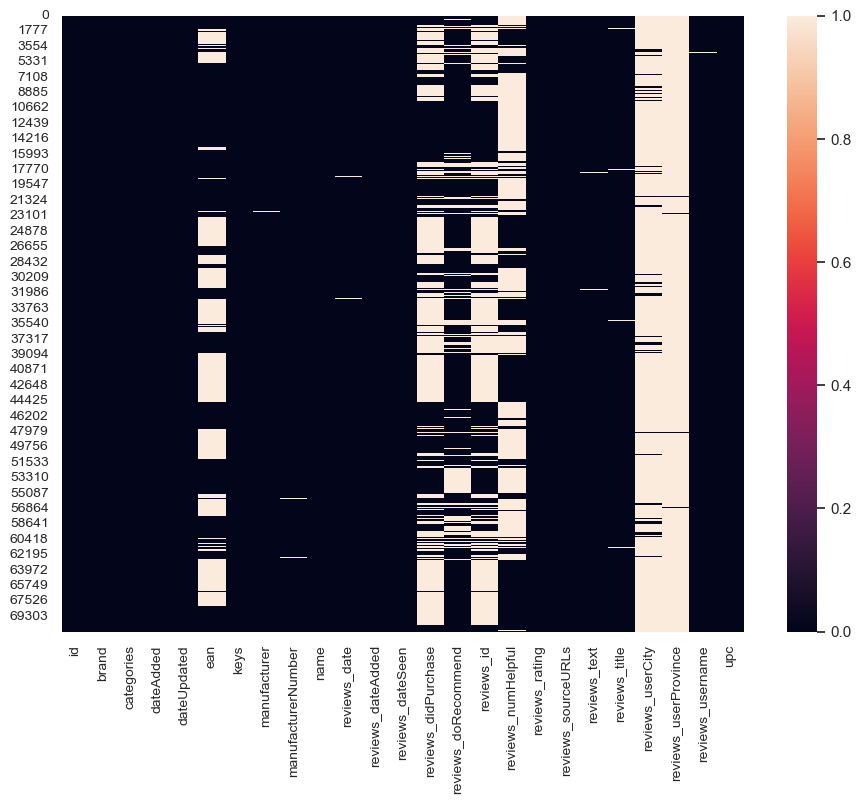

In [10]:
#visuallization of missing values
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [11]:
print('Total Missing Value Count :',df.isnull().sum().values.sum())

Total Missing Value Count : 296152


In [12]:
#Drop the columns with less than 20% of values
missing_val_threshold = len(df)*.2
df.dropna(thresh = missing_val_threshold, axis = 1, inplace=True)

In [13]:
# check shape after remove null values
df.shape

(71044, 23)

In [14]:
# Drop the rows where "reviews_text" or "reviews_date" feature has Null values
df.dropna(subset=['reviews_text','reviews_date'], inplace=True)

In [15]:
# Shape of Dataset
df.shape

(70941, 23)

In [16]:
print("Percentage of missing values :")
print(df.isna().mean().round(4) * 100)

Percentage of missing values :
id                      0.00
brand                   0.00
categories              0.00
dateAdded               0.00
dateUpdated             0.00
ean                    45.07
keys                    0.00
manufacturer            0.20
manufacturerNumber      0.28
name                    0.00
reviews_date            0.00
reviews_dateAdded       0.00
reviews_dateSeen        0.00
reviews_didPurchase    54.67
reviews_doRecommend    14.82
reviews_id             54.67
reviews_numHelpful     54.18
reviews_rating          0.00
reviews_sourceURLs      0.00
reviews_text            0.00
reviews_title           0.65
reviews_username        0.13
upc                     0.00
dtype: float64


### Combine Review text and Title into one

In [17]:
#joining review text and title
df['Review'] = df['reviews_title'].map(str) + ' ' + df['reviews_text']

In [18]:
df['Review'][0]

"Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

# 4. Nlp Text Pre-procerssing

## Lowercasing

In [19]:
#lowercasing the reviews and title column
df['Review'] = df['Review'].apply(lambda x : x.lower())
df['Review'][0]

"just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

## Remove Punctuation

In [20]:
#remove punctuation
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'][0]

'just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy'

## Remove Stopwords

In [21]:
#remove stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x : ' '.join([i for i in x.split() if i not in stop]))
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy'

## Lemmatization

In [22]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    if nltk_tag.startswith('N'):
        return wordnet.NOUN
    if nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [23]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [24]:
df['Review']=df['Review'].apply(lambda x: lemmatize_sentence(x))
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy'

## Spelling Correction

In [25]:
# spell = SpellChecker()

# df['Review']=df['Review'].apply(lambda x: ' '.join(str(spell.correction(word)) for word in nltk.word_tokenize(str(x))))
# df['Review'][0]

## Noise Removal

In [26]:
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text=text.strip()
    return text

In [27]:
df['Review']=df['Review'].apply(lambda x: scrub_words(x))
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give  star rating way metaphor crazy'

In [28]:
df.to_csv('GrammarandProductReviewsupdate.csv')

# 5. Visualization

## Word Count

In [29]:
df['Review_wc'] = df['Review'].apply(lambda x : len(str(x).split(' ')))
df[['Review_wc','Review']].head()

,Review_wc,Review
0,21,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,7,good good flavor review collect part promotion
2,3,good good flavor
3,60,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,15,irritation husband buy gel us gel caused irritation felt like burn skin wouldnt recommend gel


<AxesSubplot: xlabel='Review_wc', ylabel='Density'>

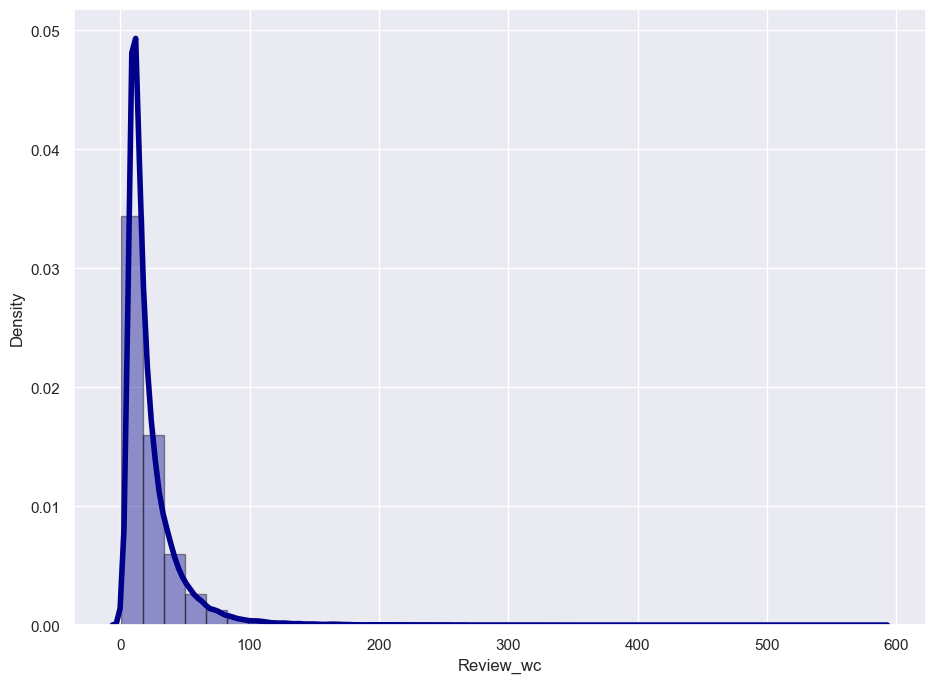

In [30]:
#density plot and histogram of all word count
sns.distplot(df['Review_wc'], hist=True, bins=int(180/5), 
            color= 'darkblue', hist_kws= {'edgecolor':'black'},
            kde_kws={'linewidth' : 4})

As we see the word typing length is 1 to 586 and mostly word typing
length lying nearly 20 to 30 words.

## Character Count

In [31]:
df['Review_cc'] = df['Review'].apply(lambda x : len(x))
df[['Review_cc', 'Review']].head()

,Review_cc,Review
0,116,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,46,good good flavor review collect part promotion
2,16,good good flavor
3,411,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,93,irritation husband buy gel us gel caused irritation felt like burn skin wouldnt recommend gel


<AxesSubplot: xlabel='Review_cc', ylabel='Density'>

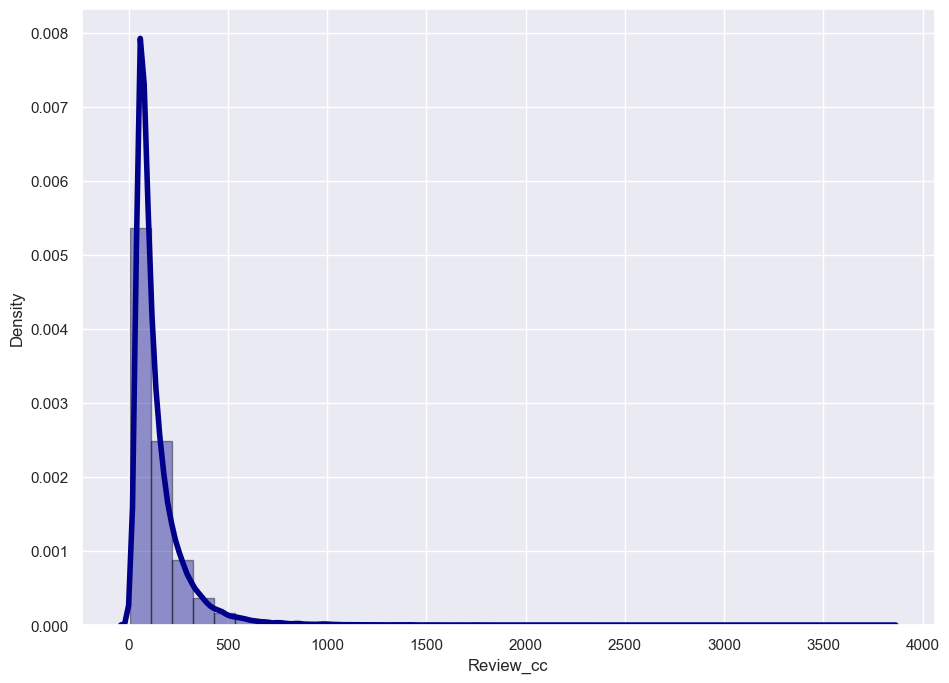

In [32]:
#density plot nd histplot of all chracter count
sns.distplot(df['Review_cc'], hist=True, bins = int(180/5),color='darkblue',
            hist_kws={'edgecolor':'black'},kde_kws={'linewidth':4})

We see that product comments take character uses between 4 to 3821.
and most comments take characters in nearly 140 letters.

## Average Word Length

In [33]:
def avg_length(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words) / len(words))

df['Review_avg'] = df['Review'].apply(lambda x: avg_length(x))
df[['Review_avg','Review']].head()

,Review_avg,Review
0,4.800000,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,5.714286,good good flavor review collect part promotion
2,4.666667,good good flavor
3,6.285714,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,5.266667,irritation husband buy gel us gel caused irritation felt like burn skin wouldnt recommend gel


<AxesSubplot: xlabel='Review_avg', ylabel='Density'>

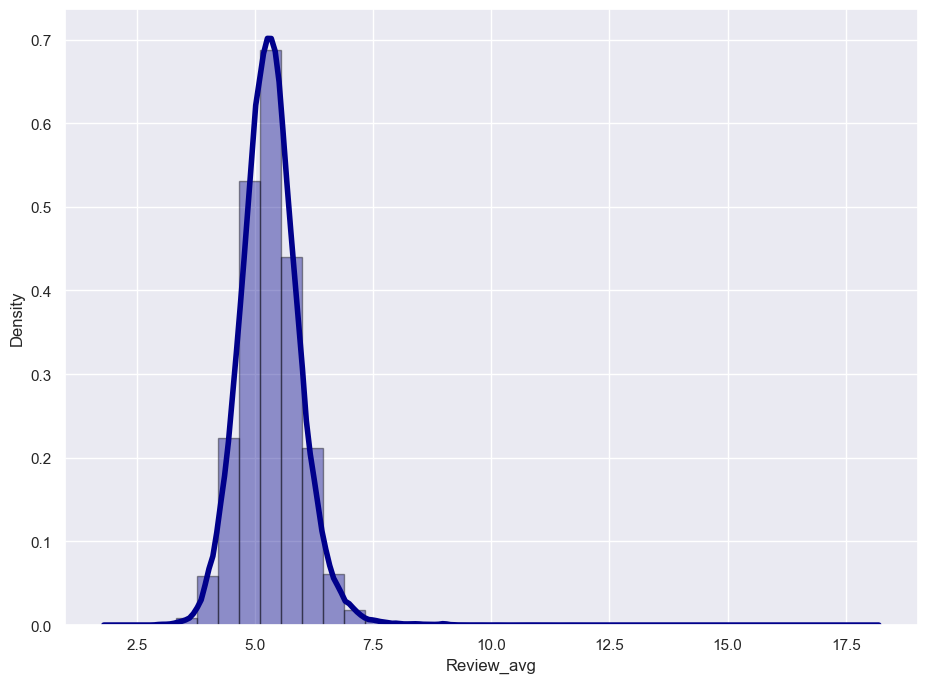

In [34]:
# Density Plot and Histogram of Average Word Length
sns.distplot(df['Review_avg'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [35]:
df['Review_avg'].describe()

count    70941.000000
mean         5.321092
std          0.626808
min          2.000000
25%          4.916667
50%          5.300000
75%          5.692308
max         18.000000
Name: Review_avg, dtype: float64

We see that product comments take average character uses between 2 to 18. and most comments take average characters in nearly 5.5 letters.

## Top 30 Common Words

In [36]:
#creat function to plot most frequent terms
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    fredist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fredist.keys()), 'count':list(fredist.values())})
    
    #selecting top 30 most frquent words use for comments
    d = words_df.nlargest(columns ='count',n=terms)
    plt.figure(figsize=(20,10))
    ax= sns.barplot(data=d, x= 'count', y='word')
    ax.set(ylabel='Word')
    plt.yticks(fontsize=15)
    plt.show()

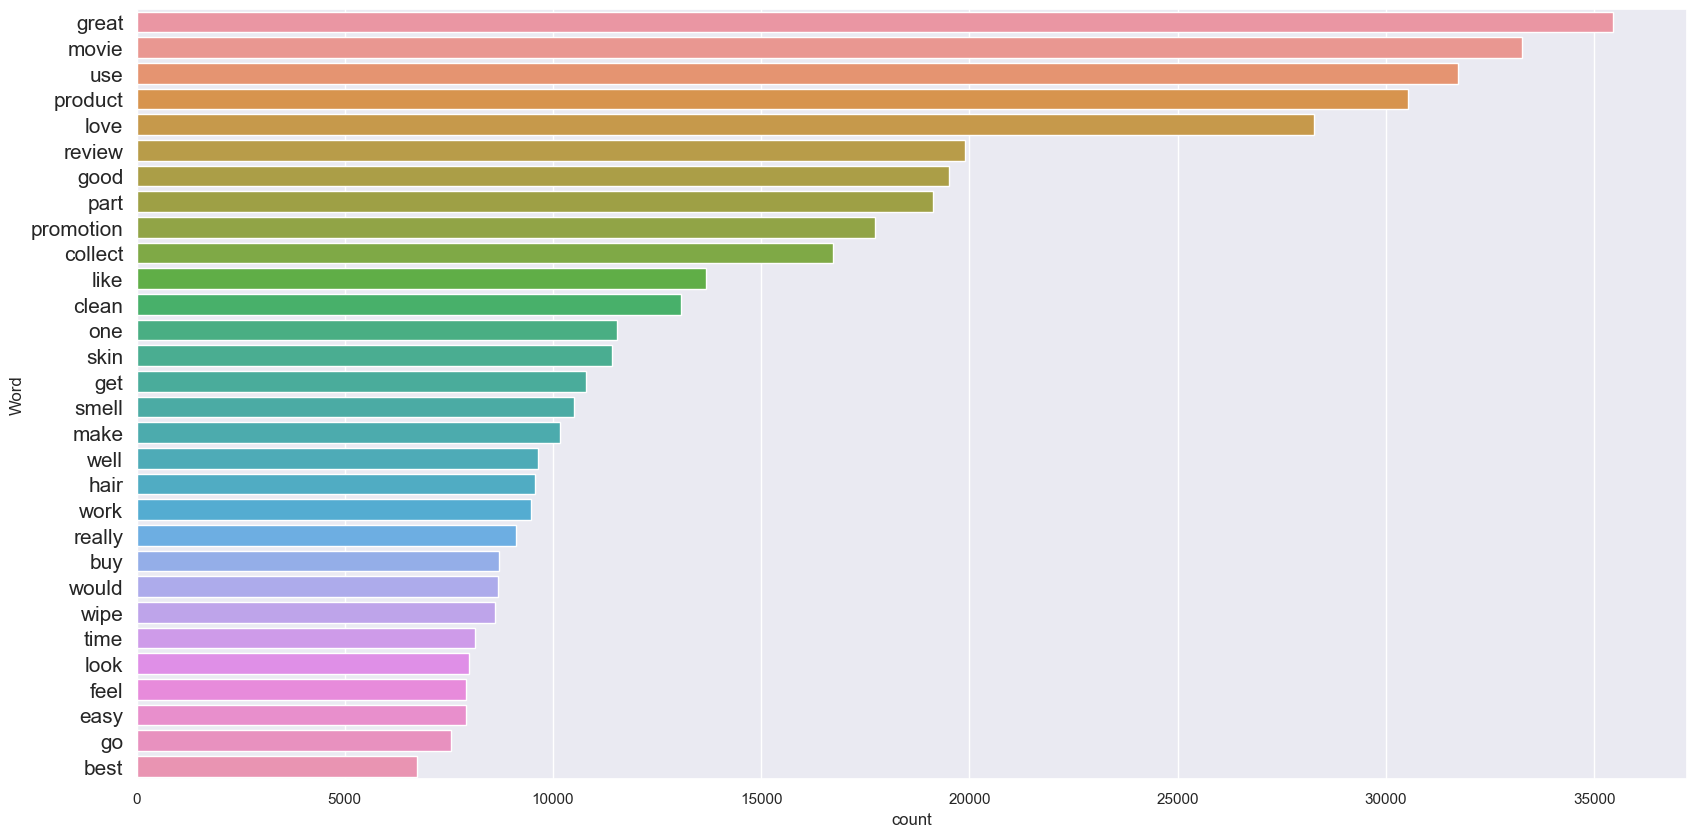

In [37]:
freq_words(df['Review'])

## Top 30 Rare Words

In [38]:
# creat function for find 30 rare words
def rare_words(x, terms=30):
    all_words=' '.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
     # selecting top 20 most frequent words
    ds = words_df.nsmallest(columns="count", n = terms) 
    plt.figure(figsize=(20,10))
    ax = sns.barplot(data=ds, x= "count", y = "word")
    ax.set(ylabel = 'Word')
    plt.yticks(fontsize=15)
    plt.show()

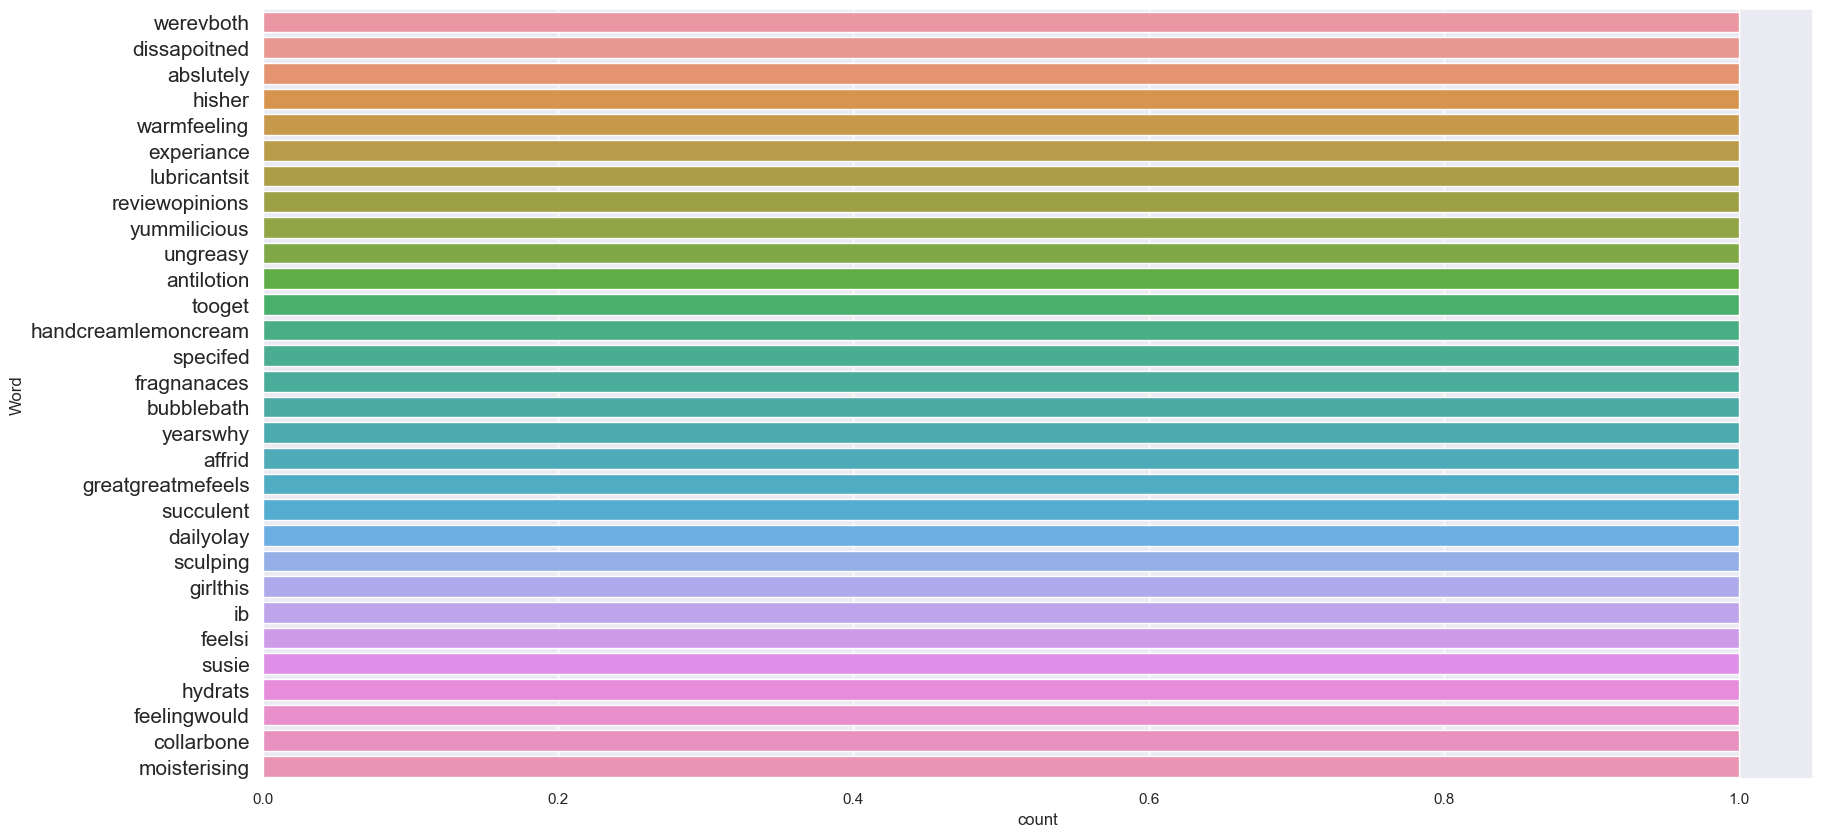

In [39]:
rare_words(df['Review'])

## Word Cloud

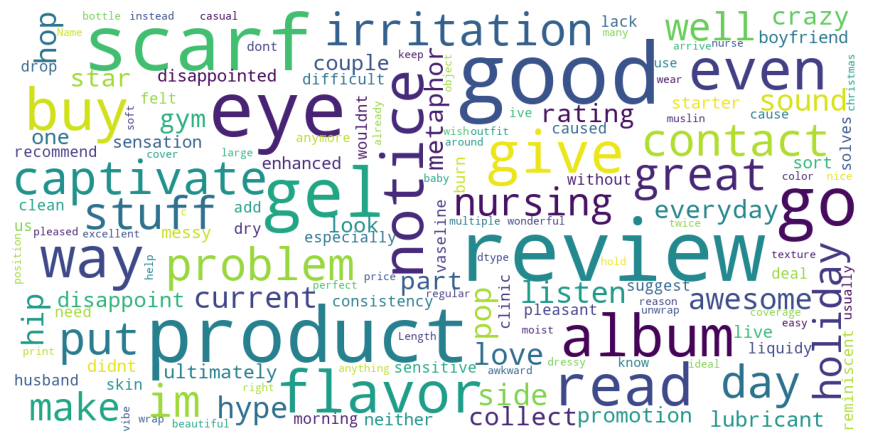

In [40]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordclouds(data):
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,
                         max_words=300, max_font_size=40,scale=3,
                         random_state=1).generate(str(data))
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

wordclouds(df['Review'])

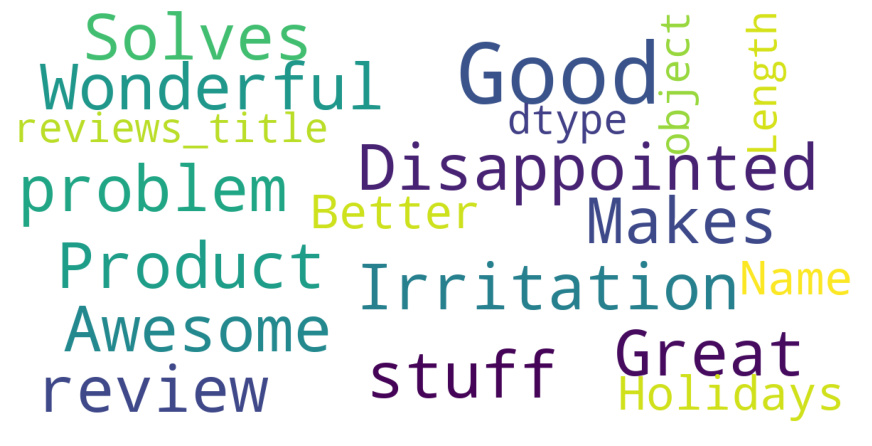

In [41]:
wordclouds(df['reviews_title'])

# 6. Basic Exploaratory Data Analysis

## Transformimg Reviews Date To Python Date Time Format

In [42]:
#convert the rating date column in datetime format
df['reviews_date'] = df['reviews_date'].str.replace(".000Z","")

In [43]:
df['reviews_date']

0        2012-11-30T06:21:45
1        2017-07-09T00:00:00
2        2017-07-09T00:00:00
3        2016-01-06T00:00:00
4        2016-12-21T00:00:00
                ...         
71039    2012-03-25T00:00:00
71040    2015-12-07T00:00:00
71041    2015-07-23T00:00:00
71042    2016-01-19T18:28:16
71043    2017-01-12T23:12:46
Name: reviews_date, Length: 70941, dtype: object

In [44]:
for i in ['brand', 'categories','manufacturer','name','reviews_id','reviews_rating']:
  print("No. of unique values in %s is : %s" %(i, df[i].nunique()))

No. of unique values in brand is : 387
No. of unique values in categories is : 575
No. of unique values in manufacturer is : 458
No. of unique values in name is : 594
No. of unique values in reviews_id is : 31372
No. of unique values in reviews_rating is : 5


## Distribution Top 25 reviews brands

<AxesSubplot: >

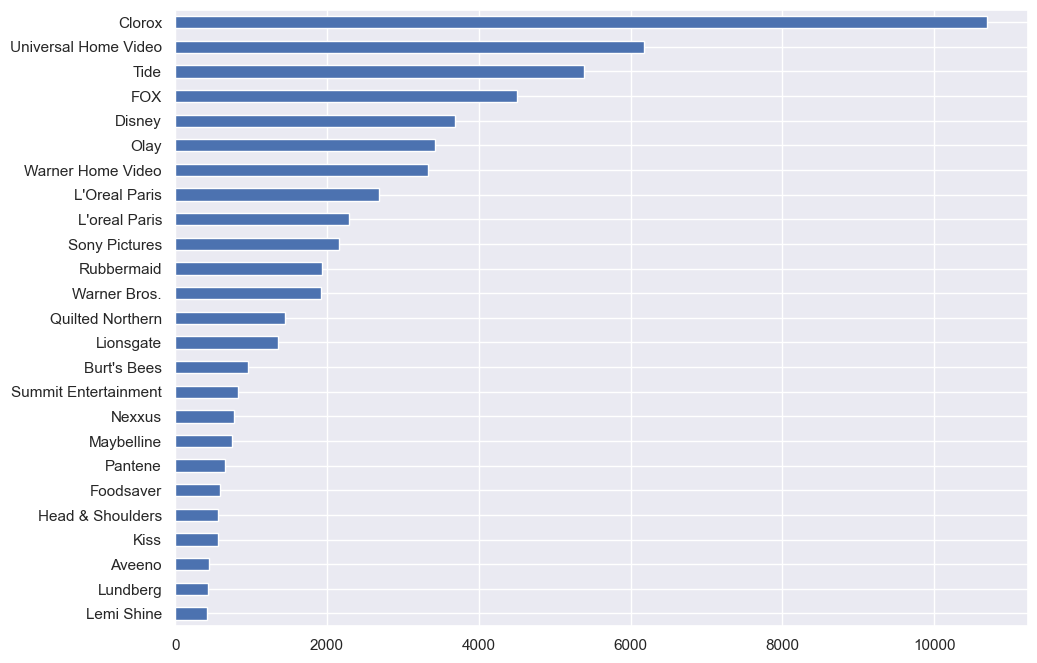

In [45]:
df['brand'].value_counts()[0:25].sort_values().plot(kind = 'barh')

## Distribution of reviewed categories

In [46]:
df["product_cat"] = df["categories"].apply(lambda x: x.split(",")[0])

In [47]:
df['product_cat'] = df['product_cat'].replace("Movies","Movies & TV Shows")
df['product_cat'] = df['product_cat'].replace("Food","Food & Beverage")
df['product_cat'] = df['product_cat'].replace("Household Chemicals","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Music on CD or Vinyl","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Pro Audio","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Baby","Kids")
df['product_cat'] = df['product_cat'].replace("Kids' Rooms","Kids")
df['product_cat'] = df['product_cat'].replace("Brand Shop","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Featured Brands","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Home Improvement","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Furniture","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Video Games","Sports & Outdoors")
df['product_cat'] = df['product_cat'].replace("Home","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Mobile","Electronics")
df['product_cat'] = df['product_cat'].replace("Photography","Electronics")
df['product_cat'] = df['product_cat'].replace("Patio & Garden","Accessories")
df['product_cat'] = df['product_cat'].replace("Gift Finder","Accessories")
df['product_cat'] = df['product_cat'].replace("Auto & Tires","Accessories")
df['product_cat'] = df['product_cat'].replace("Kitchen & Dining","Food & Beverage")


<AxesSubplot: >

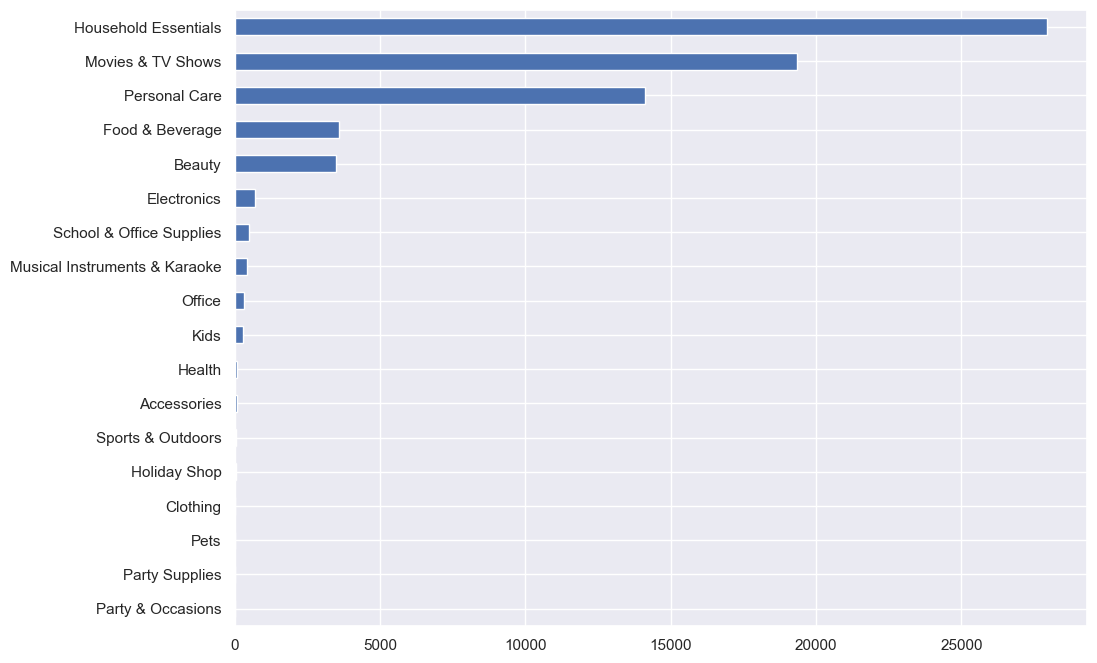

In [48]:
df['product_cat'].value_counts()[0:25].sort_values().plot(kind = 'barh')

## Distribution of top 25 reviewed manufactures

<AxesSubplot: >

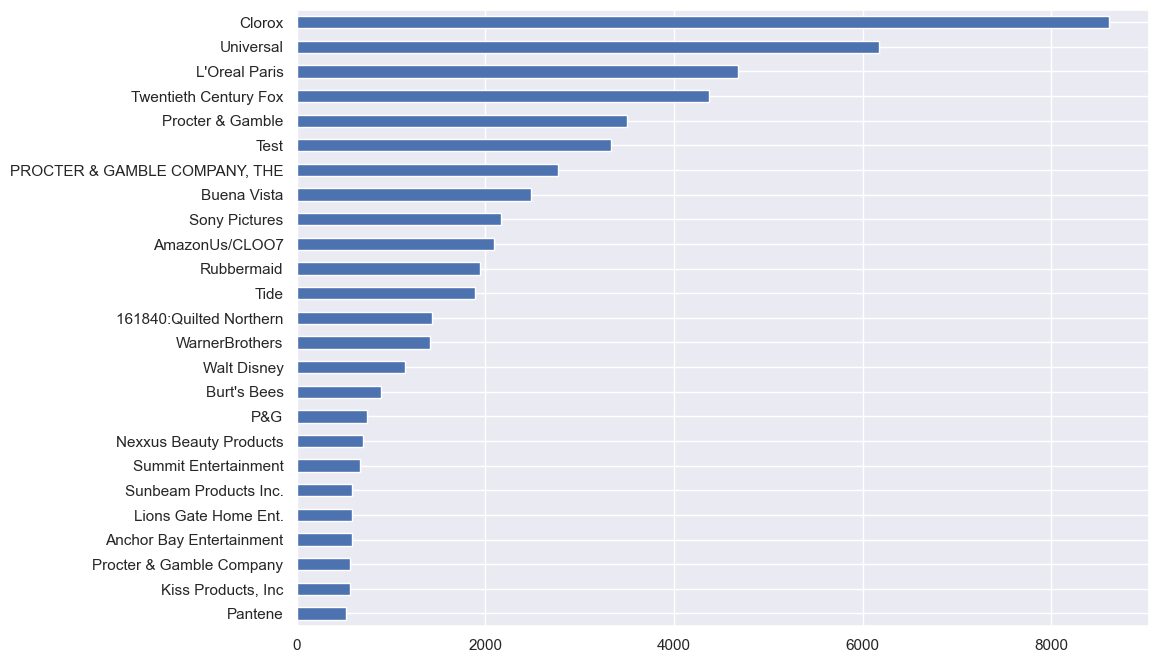

In [49]:
df['manufacturer'] = df['manufacturer'].replace("L'oreal Paris","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("SONY CORP","Sony Pictures")
df['manufacturer'].value_counts()[0:25].sort_values().plot(kind = 'barh')

## Distribution of Review Ratings

<AxesSubplot: xlabel='reviews_rating', ylabel='count'>

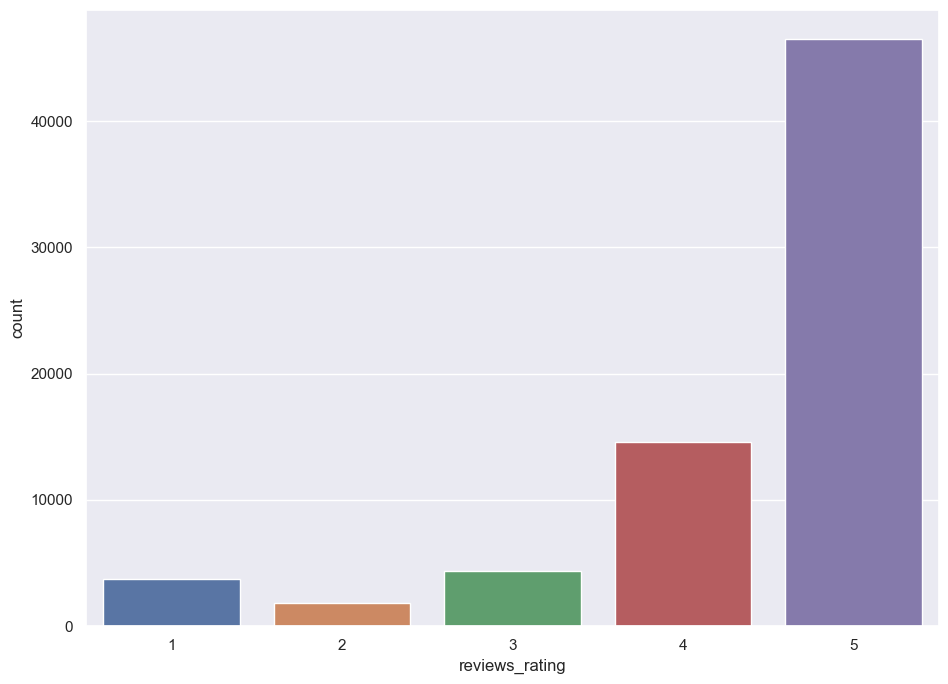

In [50]:
# Density Plot and Histogram of Reviews Ratings
sns.countplot(x=df['reviews_rating'])

MOstly comments on products are positive

## Category vs Rating

In [51]:
df['product_cat'].nunique()

18

<AxesSubplot: xlabel='count', ylabel='product_cat'>

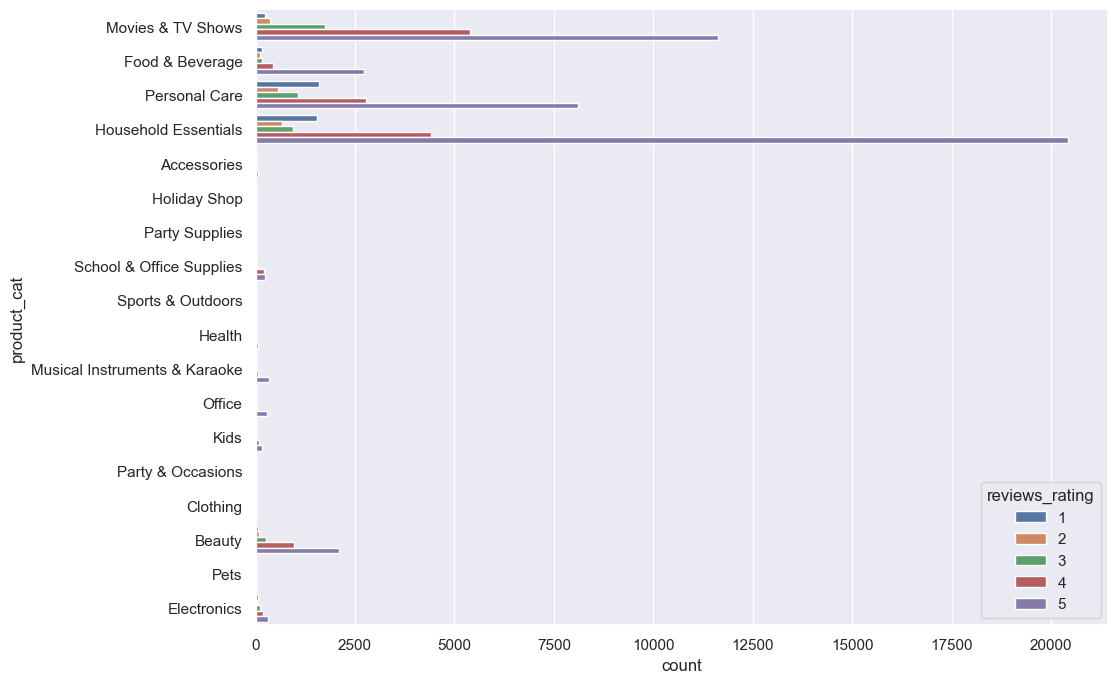

In [52]:
sns.countplot(y=df['product_cat'], hue=df['reviews_rating'])

<AxesSubplot: xlabel='count', ylabel='reviews_rating'>

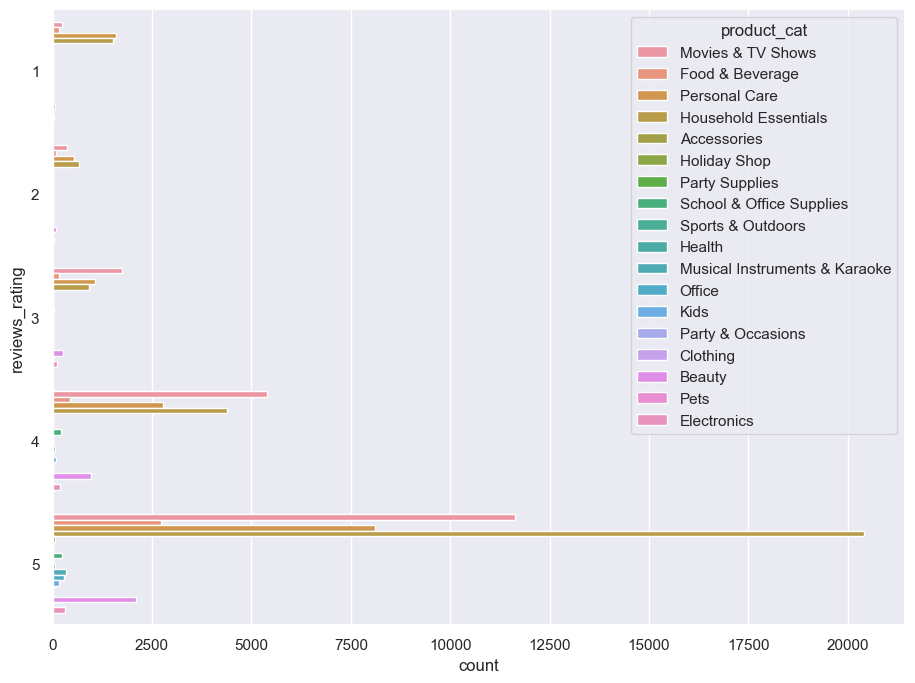

In [53]:
sns.countplot(y=df['reviews_rating'], hue=df['product_cat'])

## Brands vs Rating

<AxesSubplot: xlabel='count', ylabel='brand'>

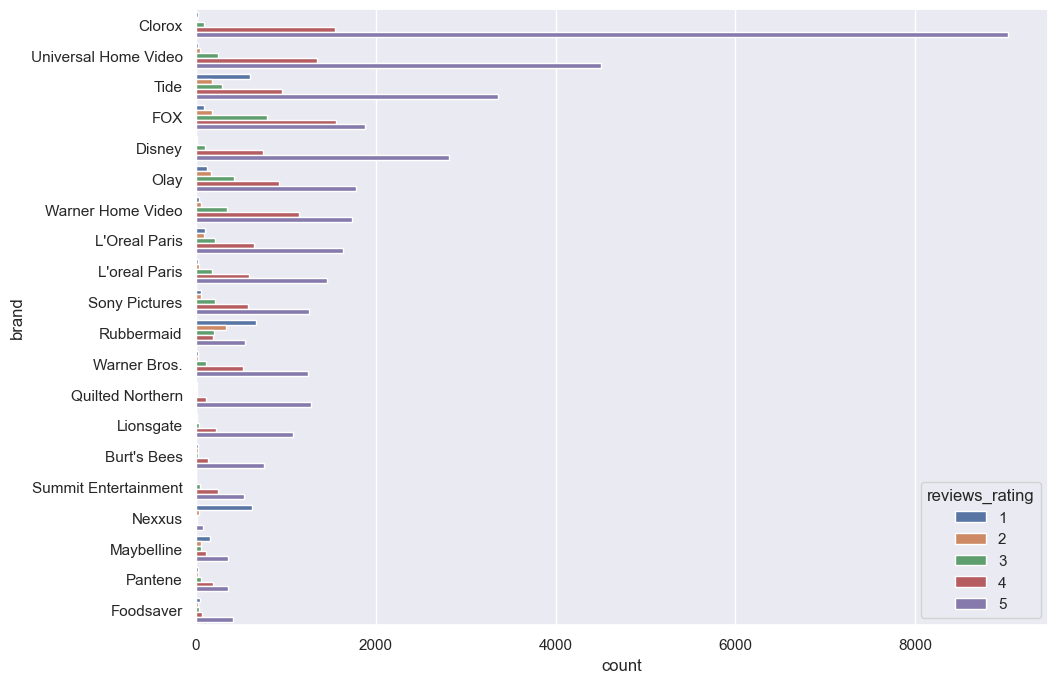

In [54]:
sns.countplot(y=df['brand'], hue=df['reviews_rating'], order=df['brand'].value_counts().iloc[:20].index)

## Most Bought Product

In [55]:
# "The Foodsaver174 10 Cup Fresh Container - Fac10-000" is purchased almost 500 times
df_genuine = df[df['reviews_didPurchase'] == True]
df_genuine['name'].value_counts()

The Foodsaver174 10 Cup Fresh Container - Fac10-000                      477
Pantene Airspray Hairspray - 7 Oz                                        443
Hormel Chili, No Beans                                                    91
Coty Airspun Face Powder, Translucent Extra Coverage                      88
Just For Men Brush-In Color Gel For Mustache & Beard, Dark Brown M-45     80
                                                                        ... 
Kenroy Home Table Lamp - Teal                                              1
Tai Pei Sweet & Sour Chicken                                               1
Lucy's Sugar Cookies, 5.5oz                                                1
Black Radiance Artisan Color Baked Blush, Warm Berry                       1
If A Man Answers (dvd)                                                     1
Name: name, Length: 304, dtype: int64

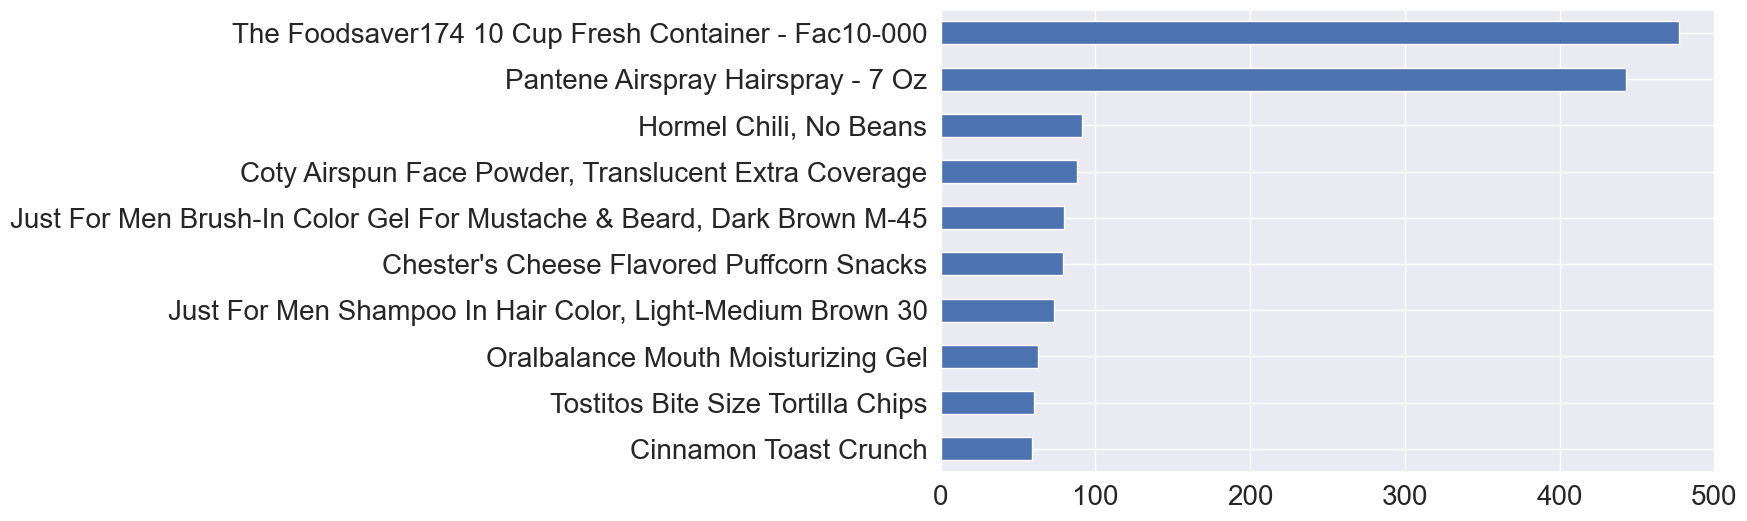

In [56]:
df_genuine['name'].value_counts()[0:10].plot(kind ='barh', figsize=[10,6], fontsize=20).invert_yaxis()

## Most purchased Product - 5 Rating

In [57]:
df_mbp = df_genuine[df_genuine['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_mbp = df_mbp[df_mbp['reviews_rating']==5]
# keep relevant columns only
df_mbp = df_mbp[[ 'reviews_rating', 'Review']]
df_mbp.head(3)

,reviews_rating,Review
46943,5,clear view content love fact see inside easy fill vacuum stack nicely take less space
46944,5,perfect size use foodsaver container overi love add longevity freshness leftover
46945,5,stay seal needed bought set well cup container use fruit lettucethey seal easily stay seal needed big improvement old container


## Most purchased Product - 1 Rating

In [58]:
# filter most purchased product with 1 star rating
df_lvp = df_genuine[df_genuine['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_lvp = df_lvp[df_lvp['reviews_rating']==1]
# keep relevant columns only
df_lvp = df_lvp[[ 'reviews_rating', 'Review']]
df_lvp.head(3)

,reviews_rating,Review
46762,1,unable use think ready use know need buy part make work
46763,1,happy buy month ago try vacuum seal seal stay day need reseal vacuum seal never stay
46765,1,unhappy can not make head tail use product sell part need


# Load Updated Dataset

df.to_csv('GrammarandProductReviewsupdate.csv')

In [2]:
df = pd.read_csv('GrammarandProductReviewsupdate.csv')
df.head()

,Unnamed: 0,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews_date,reviews_dateAdded,reviews_dateSeen,reviews_didPurchase,reviews_doRecommend,reviews_id,reviews_numHelpful,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,reviews_username,upc,Review
0,0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universalmusicgroupcashmoney/14331328,pinkfridayromanreloadedreupwdvd/000000000,pinkfridayromanreloadedreupwdvd/b009ntnhju,0602537205981",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.000Z,2017-12-20T12:28:00.000Z,2017-12-16T05:40:00.000Z,2017-12-07T09:27:00.000Z,2017-11-18T22:25:00.000Z",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/reviews/14331328?sort=helpfulness_desc&limit=200&offset=0,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Joshua,6.02537E+11,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part of a promotion.,Good,Dorothy W,73416000391,good good flavor review collect part promotion
2,2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,"lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996",Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,Dorothy W,73416000391,good good flavor
3,3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,067981934427,0067981934427,kylovesensualitypleasuregel/553550989,kylovesensualitypleasuregel/b014gk947e,ky/067981934427",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,Rebecca,67981934427,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live

In [3]:
df['reviews_rating'][df['reviews_rating'] <=3] = 0
df['reviews_rating'][df['reviews_rating'] >=4]= 1

In [4]:
df['reviews_rating'].value_counts()

1    61060
0     9881
Name: reviews_rating, dtype: int64

In [5]:
df.shape

(70941, 25)

# 7. Smote Method

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [7]:
# separate both type variable in target values
label_0 = df[df['reviews_rating'] == 0]
label_1 = df[df['reviews_rating'] == 1]

In [8]:
print('Default values:',label_0.shape)
print('Non Default values:',label_1.shape)

Default values: (9881, 25)
Non Default values: (61060, 25)


In [9]:
# now apply Downsampling for less data
y= resample(label_0, replace=True, n_samples=len(label_1),random_state=45)

In [10]:
y.shape

(61060, 25)

In [11]:
ds=pd.concat([y,label_1])  # merge both dataset value

In [12]:
ds['reviews_rating'].value_counts()

0    61060
1    61060
Name: reviews_rating, dtype: int64

In [13]:
label0=ds[ds['reviews_rating'] == 0].head(20000)
label1=ds[ds['reviews_rating'] == 1].head(20000)

In [14]:
df1= pd.concat([label1,label0])  # merge both dataset value

In [15]:
df1.shape

(40000, 25)

In [16]:
df1['reviews_rating'].value_counts()

1    20000
0    20000
Name: reviews_rating, dtype: int64

# 8. Training Data Preparation

## Defining features and target variables

In [17]:
x=df1['Review']
y=df1['reviews_rating']

## Using the n-gram tfidf vectorizer

In [19]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english')
    #ngram_range=(1, 3)   

# word_vectorizer.fit(x)
# train_features = word_vectorizer.transform(x)
x=word_vectorizer.fit_transform(x).toarray()

In [20]:
# char_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='char',
#     stop_words='english',
#     ngram_range=(2, 6),
#     max_features=50000)

# char_vectorizer.fit(x)
# train_char_features = char_vectorizer.transform(x)

# train_features = hstack([train_char_features, train_word_features])

# 9.Decomposition Dataset

In [21]:
from sklearn.decomposition import TruncatedSVD

In [22]:
svd = TruncatedSVD(n_components = 4)
x= svd.fit_transform(x)

In [23]:
x.shape

(40000, 4)

# 9. Modelling

In [24]:
# classification library
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#ensemble library
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# diffrent type of linear model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# diffrent type of algorithms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, plot_roc_curve

In [25]:
# Creating instances for different Classifiers
LO= LogisticRegression()
GA= GaussianNB()
#MU= MultinomialNB()
KN= KNeighborsClassifier()
SV= SVC()
DT= DecisionTreeClassifier()
AD= AdaBoostClassifier()
GR= GradientBoostingClassifier()
RF= RandomForestClassifier()
XG= xgb.XGBClassifier(objective="reg:linear", random_state=42)

# Creating a list model where all the models will be appended for further evaluation in loop.
models=[]
models.append(('LogisticRegression',LO))
#models.append(('MultinomialNB',MU))
# models.append(('GaussianNB',GA))
# models.append(('SupportVector',SV))
models.append(('DecisionTreeClassifier',DT))
models.append(('KneighborsClassifier',KN))
models.append(('AdaBoostClassifier',AD))
models.append(('GradientBoostingClassifier',GR))
models.append(('RandomForestClassifier',RF))
models.append(('XGBClassifier',XG))

****************************** LogisticRegression ******************************
The maximum accuracy score of LogisticRegression is 0.8078333333333333 is achieved at 13




Accuracy_Score:  79.75


Accuracy Score of Model  : 80.44285714285714


AUC_Score: 79.72715483025462


At cv=9,mean_score is 0.7885297472379409.The test accuracy_score is 0.7975 and train accuracy is 0.8044285714285714.


Cross Validation Score:  78.85297472379409


Precision Score: 87.62428601650095


Recall_Score:  69.18323033238684


F1 Score:  77.31939518387156


Confusion matrix: 

[[5428  585]
 [1845 4142]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      6013
           1       0.88      0.69      0.77      5987

    accuracy                           0.80     12000
   macro avg       0.81      0.80      0.80     12000
weighted avg       0.81      0.80      0.80     12000



<Figure size 500x500 with 0 Axes>

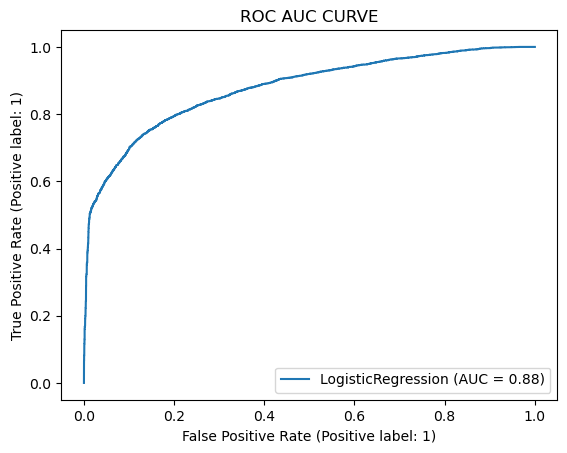





****************************** DecisionTreeClassifier ******************************
The maximum accuracy score of DecisionTreeClassifier is 0.88625 is achieved at 16




Accuracy_Score:  88.01666666666667


Accuracy Score of Model  : 99.97500000000001


AUC_Score: 88.00740203474844


At cv=9,mean_score is 0.8820533628165966.The test accuracy_score is 0.8801666666666667 and train accuracy is 0.99975.


Cross Validation Score:  88.29534303261597


Precision Score: 91.52820887347087


Recall_Score:  83.7314180724904


F1 Score:  87.45638520586184


Confusion matrix: 

[[5549  464]
 [ 974 5013]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      6013
           1       0.92      0.84      0.87      5987

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



<Figure size 500x500 with 0 Axes>

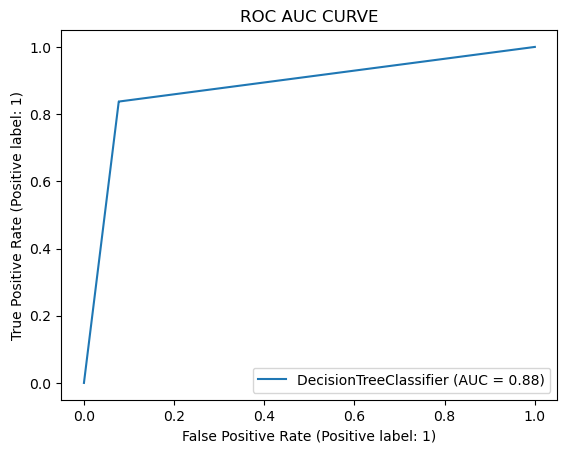





****************************** KneighborsClassifier ******************************
The maximum accuracy score of KneighborsClassifier is 0.8401666666666666 is achieved at 30




Accuracy_Score:  83.16666666666667


Accuracy Score of Model  : 88.74642857142857


AUC_Score: 83.1569459312184


At cv=9,mean_score is 0.8257538521006207.The test accuracy_score is 0.8316666666666667 and train accuracy is 0.8874642857142857.


Cross Validation Score:  82.57538521006207


Precision Score: 86.37447276728406


Recall_Score:  78.67045264740271


F1 Score:  82.34265734265735


Confusion matrix: 

[[5270  743]
 [1277 4710]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6013
           1       0.86      0.79      0.82      5987

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000



<Figure size 500x500 with 0 Axes>

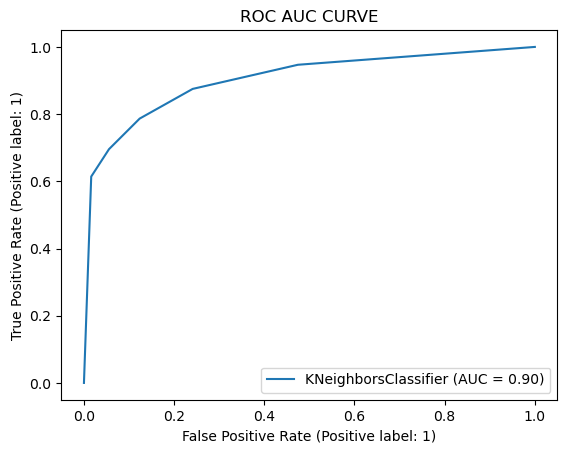





****************************** AdaBoostClassifier ******************************
The maximum accuracy score of AdaBoostClassifier is 0.8198333333333333 is achieved at 13




Accuracy_Score:  81.19166666666666


Accuracy Score of Model  : 81.71071428571427


AUC_Score: 81.17967970460751


At cv=9,mean_score is 0.7961050323255048.The test accuracy_score is 0.8119166666666666 and train accuracy is 0.8171071428571428.


Cross Validation Score:  79.61050323255049


Precision Score: 85.00375375375376


Recall_Score:  75.64723567730081


F1 Score:  80.05302695536899


Confusion matrix: 

[[5214  799]
 [1458 4529]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      6013
           1       0.85      0.76      0.80      5987

    accuracy                           0.81     12000
   macro avg       0.82      0.81      0.81     12000
weighted avg       0.82      0.81      0.81     12000



<Figure size 500x500 with 0 Axes>

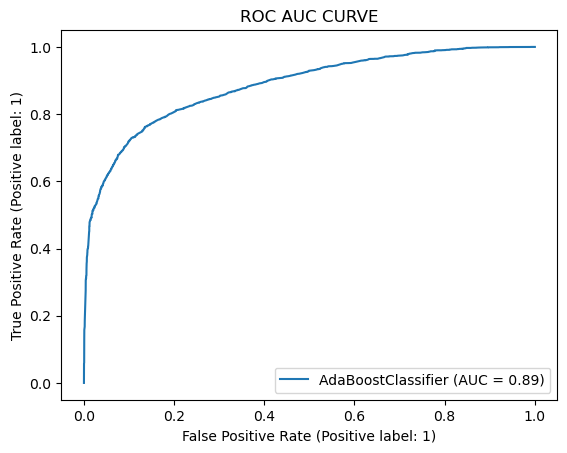





****************************** GradientBoostingClassifier ******************************
The maximum accuracy score of GradientBoostingClassifier is 0.8335833333333333 is achieved at 14




Accuracy_Score:  82.27499999999999


Accuracy Score of Model  : 83.35000000000001


AUC_Score: 82.25991255347839


At cv=9,mean_score is 0.8155793532109116.The test accuracy_score is 0.82275 and train accuracy is 0.8335.


Cross Validation Score:  81.5529353835271


Precision Score: 87.43211792086889


Recall_Score:  75.29647569734425


F1 Score:  80.91178318226689


Confusion matrix: 

[[5365  648]
 [1479 4508]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6013
           1       0.87      0.75      0.81      5987

    accuracy                           0.82     12000
   macro avg       0.83      0.82      0.82     12000
weighted avg       0.83      0.82      0.82     12000



<Figure size 500x500 with 0 Axes>

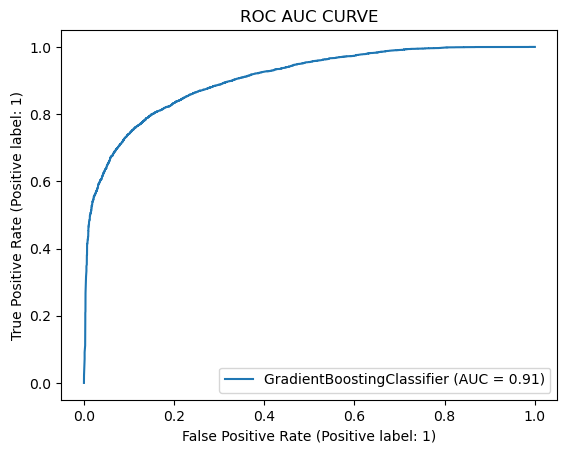





****************************** RandomForestClassifier ******************************
The maximum accuracy score of RandomForestClassifier is 0.9003333333333333 is achieved at 31




Accuracy_Score:  89.39166666666667


Accuracy Score of Model  : 99.97142857142856


AUC_Score: 89.37989875563582


At cv=9,mean_score is 0.8896030660433871.The test accuracy_score is 0.8939166666666667 and train accuracy is 0.9997142857142857.


Cross Validation Score:  89.0303046052637


Precision Score: 94.15511427500937


Recall_Score:  83.9485552029397


F1 Score:  88.75938189845475


Confusion matrix: 

[[5701  312]
 [ 961 5026]]


Classification Report:
 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      6013
           1       0.94      0.84      0.89      5987

    accuracy                           0.89     12000
   macro avg       0.90      0.89      0.89     12000
weighted avg       0.90      0.89      0.89     12000



<Figure size 500x500 with 0 Axes>

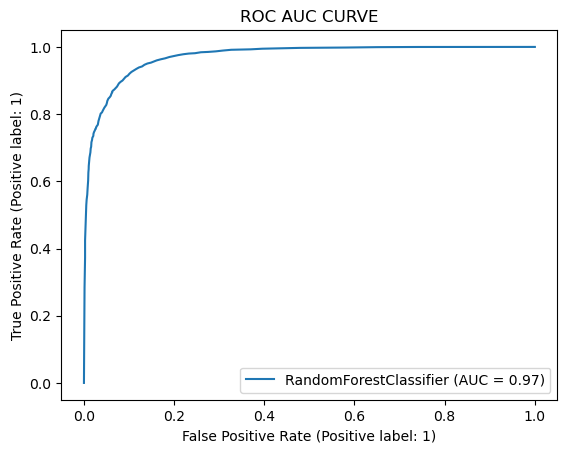





****************************** XGBClassifier ******************************
[06:04:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederr

[06:05:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

[06:05:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
At cv=9,mean_score is 0.841753551058143.The test accuracy_score is 0.8481666

<Figure size 500x500 with 0 Axes>

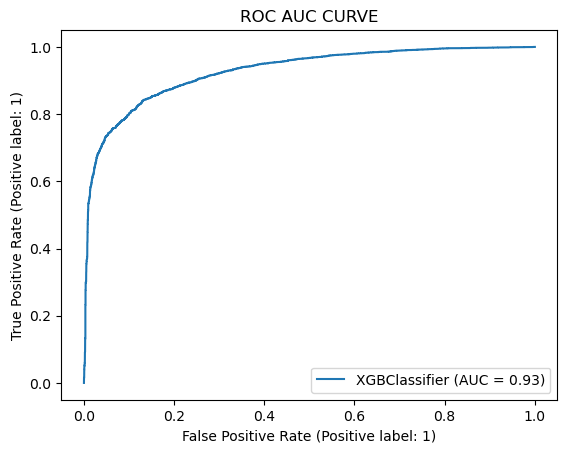

In [26]:
# Creating empty lists
Model = []
Acc_score = []
Model_score=[]
cvs = []
Precision_Score=[]
Roc_score=[]
Recall_score=[]
F1_Score=[]

for name,model in models:
    print("******************************",name,"******************************")
    # Determining Best Random State
    max_score=0
    for r_state in range(5,35):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=r_state,test_size=0.30)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        acc_score=accuracy_score(y_test,pred)
        if acc_score>max_score:
            max_score=acc_score
            final_r_state=r_state
    print("The maximum accuracy score of", name ,"is", max_score, "is achieved at", final_r_state)
    print("\n")
    
    #Model.append(name)
    Model.append(name)
    model.fit(x_train,y_train)
    print('\n')
    
    #print(model)
    y_pred=model.predict(x_test)
    
    # Accuracy Score
    acc_score=accuracy_score(y_test,y_pred)*100
    print('Accuracy_Score: ',acc_score)
    Acc_score.append(acc_score)
    print('\n')
    
    #trainning score
    pred_train=model.predict(x_train)
    Score=accuracy_score(y_train,pred_train)*100
    print(f"Accuracy Score of Model  : {(accuracy_score(y_train,pred_train)*100)}")
    Model_score.append(Score)
    print('\n')
    
    #roc_score
    auc_score=roc_auc_score(y_test,y_pred)*100
    print('AUC_Score:',auc_score)
    Roc_score.append(auc_score)
    print('\n')
    
    # Determining Best cv random State
    max_cv =0
    test=model.predict(x_test)
    train=model.predict(x_train)
    for i in range(2,10):
        cv_score=cross_val_score(model,x,y,cv=i)
        mean_score=cv_score.mean()
        if mean_score > max_cv:
            max_cv = mean_score
            final_cv=i
    print(f"At cv={final_cv},mean_score is {max_cv}.The test accuracy_score is {accuracy_score(y_test,test)} and train accuracy is {accuracy_score(y_train,train)}.")
    print('\n')      
    
    # Cross Validation Score
    cv=cross_val_score(model,x,y,cv=final_cv,scoring='accuracy').mean()*100
    print('Cross Validation Score: ',cv)
    cvs.append(cv)
    print('\n')
    
    #Pricision Score
    print('Precision Score:', precision_score(y_test,y_pred)*100)
    pre_score=precision_score(y_test,y_pred)*100
    Precision_Score.append(pre_score)
    print('\n')
    
    # Recall Score
    recal_score=recall_score(y_test,y_pred)*100
    print('Recall_Score: ',recal_score)
    Recall_score.append(recal_score)
    print('\n')

    
    # f1 Score
    f1_scor=f1_score(y_test,y_pred)*100
    print('F1 Score: ',f1_scor)
    F1_Score.append(f1_scor)
    print('\n')
    
    # Confusion Matrix
    print('Confusion matrix: \n')
    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    print("\n")
    
    # Classification Report
    print('Classification Report:\n ')
    print(classification_report(y_test,y_pred))
    
    #roc_curve
    plt.figure(figsize=(5,5))
    plot_roc_curve(model,x_test,y_test)
    plt.title('ROC AUC CURVE')
    plt.show()
    print('\n')
    print('\n')

In [27]:
# Displaying Scores and metrics:
Results=pd.DataFrame({'Model': Model,'Accuracy Score': Acc_score,'Dataset_score':Model_score,'Cross Validation Score':cvs,
                      'Precision':Precision_Score,'Recall_Score':Recall_score,'F1_Score':F1_Score,
                      'Roc_Score':Roc_score,}) 
Results

,Model,Accuracy Score,Dataset_score,Cross Validation Score,Precision,Recall_Score,F1_Score,Roc_Score
0,LogisticRegression,79.750000,80.442857,78.852975,87.624286,69.183230,77.319395,79.727155
1,DecisionTreeClassifier,88.016667,99.975000,88.295343,91.528209,83.731418,87.456385,88.007402
2,KneighborsClassifier,83.166667,88.746429,82.575385,86.374473,78.670453,82.342657,83.156946
3,AdaBoostClassifier,81.191667,81.710714,79.610503,85.003754,75.647236,80.053027,81.179680
4,GradientBoostingClassifier,82.275000,83.350000,81.552935,87.432118,75.296476,80.911783,82.259913
5,RandomForestClassifier,89.391667,99.971429,89.030305,94.155114,83.948555,88.759382,89.379899
6,XGBClassifier,84.816667,90.457143,84.175355,89.359289,78.971104,83.844653,84.804029


In [28]:
Minus=Results['Accuracy Score'] - Results['Cross Validation Score']

In [29]:
Minus

0    0.897025
1   -0.278676
2    0.591281
3    1.581163
4    0.722065
5    0.361362
6    0.641312
dtype: float64

In [30]:
Fitting=Results['Dataset_score'] - Results['Accuracy Score']
Fitting

0     0.692857
1    11.958333
2     5.579762
3     0.519048
4     1.075000
5    10.579762
6     5.640476
dtype: float64

# Best Model By Cv Score and Train Test Split

### Here we choose the best model for this dataset by Following Conditions: -->
    
1. Minimum Difference Between Accuracy Score And CV Score

2. Minimum Difference Between Train And Test Data

Both Conditions Is Satisfied By Only Gradient Boosting Algorithms if we ignored fitting then Random Forest Algorithms is
Best Model So We Apply HyperTuning On Both These Models For Getting Best Model For Our Dataset.

# Hyper Tuning For Random Forest Algorithms

In [39]:
dict1={'criterion':['gini','entropy','log_loss'],'max_features':['sqrt','log2','None'],'n_estimators':[100,200,300,400]}

In [40]:
Gs=GridSearchCV(RF,dict1,cv=9)
Gs.fit(x,y)

GridSearchCV(cv=9, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2', 'None'],
                         'n_estimators': [100, 200, 300, 400]})

In [41]:
Gs.best_score_

0.8916529448220412

In [42]:
Gs.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 300}

# Analysis By HyperTuning Feature

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Confusion Matrix : [[5710  303]
 [ 936 5051]]
Classification Report :               precision    recall  f1-score   support

           0       0.86      0.95      0.90      6013
           1       0.94      0.84      0.89      5987

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000

Accuracy Score of Model  : 89.67500000000001


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Dataset Score : 99.97500000000001
Precision Score: 94.34067986552111
Recall_score:84.3661266076499
F1_score:89.0750374746495


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


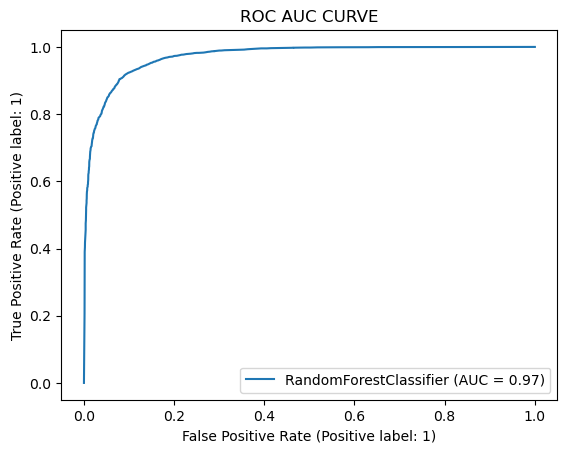

In [52]:
Rfc=RandomForestClassifier(criterion='gini',max_features='log2',n_estimators=300,n_jobs=1, verbose=1)
Rfc.fit(x_train,y_train)
pred_test=Rfc.predict(x_test)
print(f"Confusion Matrix : {confusion_matrix(y_test,pred_test)}")
print(f"Classification Report : {classification_report(y_test,pred_test)}")
print(f"Accuracy Score of Model  : {(accuracy_score(y_test,pred_test)*100)}")  #accuracy score of testing data
print(f"Dataset Score : {(Rfc.score(x_train,y_train))*100}")    #model working with dataset
print('Precision Score:', precision_score(y_test,pred_test)*100)   #precision score for how accurate our prediction
print(f"Recall_score:{recall_score(y_test,pred_test)*100}")   #recall score
print(f"F1_score:{f1_score(y_test,pred_test)*100}")  #f1_score
plot_roc_curve(Rfc,x_test,y_test)   # roc currve
plt.title('ROC AUC CURVE')
plt.show()

When we compare both Type of model than we findf that our model not have improvement so we try another model 

# HyperTuning By Gradient Boosting

In [45]:
dict1={'criterion':['friedman_mse', 'squared_error'],'max_features':['sqrt','log2'],'n_estimators':[100,200,300,400]}

In [46]:
Gs=GridSearchCV(GR,dict1,cv=9)
Gs.fit(x,y)

GridSearchCV(cv=9, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400]})

In [47]:
Gs.best_score_

0.8211789401662326

In [48]:
Gs.best_params_

{'criterion': 'squared_error', 'max_features': 'log2', 'n_estimators': 400}

# Analysis By HyperTuning Feature

      Iter       Train Loss   Remaining Time 
         1           1.3116            6.99s
         2           1.2532            7.44s
         3           1.1966            6.25s
         4           1.1472            6.16s
         5           1.1154            6.16s
         6           1.0809            6.14s
         7           1.0567            6.13s
         8           1.0296            6.12s
         9           1.0109            6.10s
        10           0.9895            6.09s
        20           0.8782            5.81s
        30           0.8248            5.50s
        40           0.7933            5.37s
        50           0.7755            5.27s
        60           0.7637            5.12s
        70           0.7567            4.98s
        80           0.7501            4.83s
        90           0.7449            4.62s
       100           0.7386            4.49s
       200           0.7065            3.13s
       300           0.6820            1.55s
       40

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Dataset Score : 99.97500000000001
Precision Score: 87.52602687866742
Recall_score:77.23400701519961
F1_score:82.05856255545697


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished


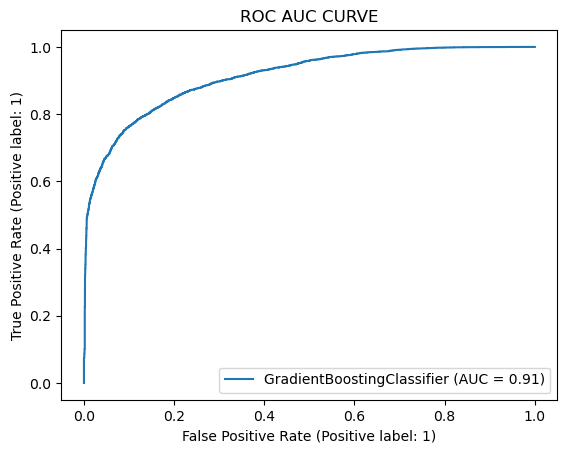

In [50]:
Grc=GradientBoostingClassifier(criterion='squared_error',max_features='log2',n_estimators=400, verbose=1)
Grc.fit(x_train,y_train)
pred_test=Grc.predict(x_test)
print(f"Confusion Matrix : {confusion_matrix(y_test,pred_test)}")
print(f"Classification Report : {classification_report(y_test,pred_test)}")
print(f"Accuracy Score of Model  : {(accuracy_score(y_test,pred_test)*100)}")  #accuracy score of testing data
print(f"Dataset Score : {(Rfc.score(x_train,y_train))*100}")    #model working with dataset
print('Precision Score:', precision_score(y_test,pred_test)*100)   #precision score for how accurate our prediction
print(f"Recall_score:{recall_score(y_test,pred_test)*100}")   #recall score
print(f"F1_score:{f1_score(y_test,pred_test)*100}")  #f1_score
plot_roc_curve(Grc,x_test,y_test)   # roc currve
plt.title('ROC AUC CURVE')
plt.show()

After Conclusion i find that i take less data for modling purpose and by this i got some overfitting condition in my model.so i go with Ranmdom Forest Classifier for best model.In this i got High Acuracy and Less diffrence betwenn cv score and Accuracy score and high Roc Value and AUC value

# Save Best Model 

In [51]:
import joblib

In [53]:
joblib.dump(Rfc,'ProductReview.pkl')

['ProductReview.pkl']